# EPA-1361 Model-Based Decision-Making 

## Final Assignment: Aggregated Problem Formulation (PF2)

**Instructor:** J.H. Kwakkel & J.A. de Bruijn <br>
**Group 27:** R. Arab, L. Hu, H. Isenia Bustamante, P. Lotfi, K. Konst, M. Nawaz <br>
**Delft University of Technology | Q4 2021** <br>

---

This notebook is intended to provide the necessary insights into the implications of flood risk management from the aggregated perspective, namely problem formulation 2. To minimize the lead time of the various deep uncertainty methods used in this analysis, this notebook uses the data from multiple experiments *(combination of scenario and policy)* performed beforehand. To ensure the reproducibility of this analysis, the code of these experiments are listed as pseudo code. <br> 

**Note: To perform any individual analysis, parts 1 (Imported Libraries) and 2 (Pre-Analysis) of this notebook must first be performed.**<br> 

## Table of Content
1. Imported Libraries
2. Pre-Analysis
3. Open Exploration <br>
    3.1. Model Behaviour <br>
    3.2. Worst Case Scenario (WCS) <br>
4. Vulnerability Analysis <br>
    4.1. Sensitivity Analysis: Extra Trees <br>
    4.2. Scenario Discovery: PRIM <br>
5. Multi-Objective Robust Optimalization (MORO)

## 1. Imported Libraries
In this section of the notebook the different libraries used are listed and imported.

In [1]:
import numpy as np
import random
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import functools
import time
import copy

In [2]:
from ema_workbench import (Model, CategoricalParameter, ScalarOutcome, IntegerParameter, 
                           RealParameter, Policy, save_results, load_results, Scenario, MultiprocessingEvaluator)
from ema_workbench.em_framework.evaluators import perform_experiments
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.em_framework.samplers import sample_uncertainties
from ema_workbench.analysis import feature_scoring, prim
from ema_workbench.analysis.scenario_discovery_util import RuleInductionType
from dike_model_function import DikeNetwork  # @UnresolvedImport
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench.analysis import pairs_plotting
from ema_workbench.util import ema_logging

## 2. Pre-Analysis
In this section of the notebook the elements needed to perform any of the deep uncertainty methods of this analysis are lists and imports.

In [3]:
# make sure pandas is version 1.0 or higher
# make sure networkx is verion 2.4 or higher
print(pd.__version__)
print(nx.__version__)

1.0.5
2.4


In [4]:
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)

#choose problem formulation number, between 0-7
#each problem formulation has its own list of outcomes
dike_model, planning_steps = get_model_for_problem_formulation(2)

In [5]:
#enlisting uncertainties, their types (RealParameter/IntegerParameter/CategoricalParameter), lower boundary, and upper boundary
#for unc in dike_model.uncertainties:
    #print(repr(unc))
    
uncertainties = dike_model.uncertainties
uncertainties = copy.deepcopy(dike_model.uncertainties)

#enlisting policy levers, their types (RealParameter/IntegerParameter), lower boundary, and upper boundary
#for policy in dike_model.levers:
    #print(repr(policy))
    
levers = dike_model.levers 
levers = copy.deepcopy(dike_model.levers)

In [6]:
#define policy with absence of flood risk management (without policies)
policy_0 = Policy("no release", **{l.name:0 for l in dike_model.levers})

## 3. Open Exploration
In this section of the notebook, the uncertainty space is explored using open exploration. For clarity, the model behaviour is first explored (3.1) and then the worst case scenario is performed (3.2).

### 3.1. Model Behaviour

The code of the experimental setup for the model behaviour in pseudo code is:

```python
from ema_workbench import (MultiprocessingEvaluator, save_results)
from ema_workbench.em_framework.evaluators import perform_experiments

random.seed(3922875)
n_scenarios = 5000

with MultiprocessingEvaluator(dike_model) as evaluator: 
    pf2_results = evaluator.perform_experiments(n_scenarios, policy_0)

save_results((pf2_results), './results/base_exploration_aggregated.tar.gz')
```

In [7]:
#run to load results
pf2_results = load_results('./results/base_exploration_aggregated.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/hillaryiseniabustamante/Desktop/epa1361_open-master 2/final assignment/results/base_exploration_aggregated.tar.gz


In [8]:
pf2_experiments, pf2_outcomes = pf2_results

### Pair-Scatter Plot

[MainProcess/INFO] no time dimension found in results


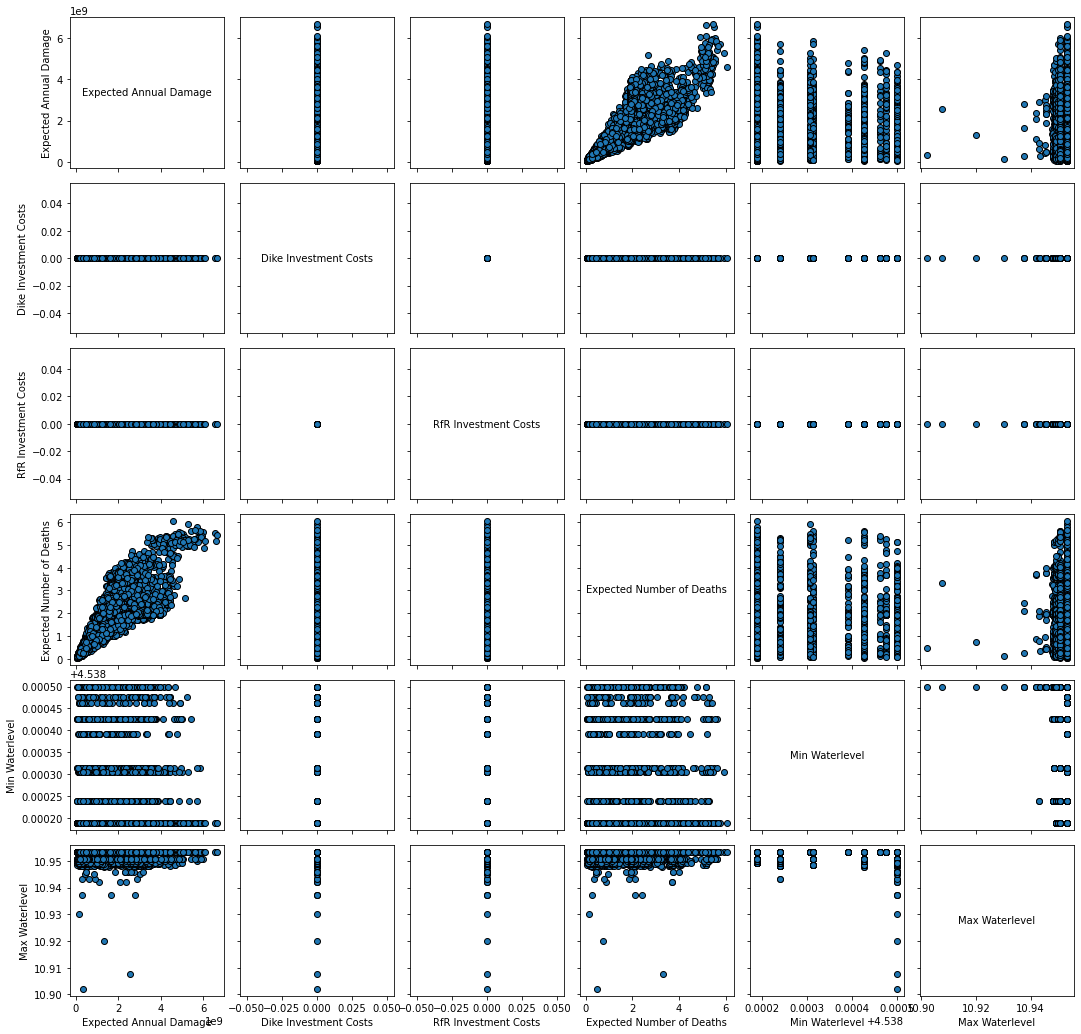

In [9]:
pairs_plotting.pairs_scatter(pf2_experiments, pf2_outcomes)

fig = plt.gcf()
fig.set_size_inches(18,18)

plt.show()

### Histograms

<function matplotlib.pyplot.show(close=None, block=None)>

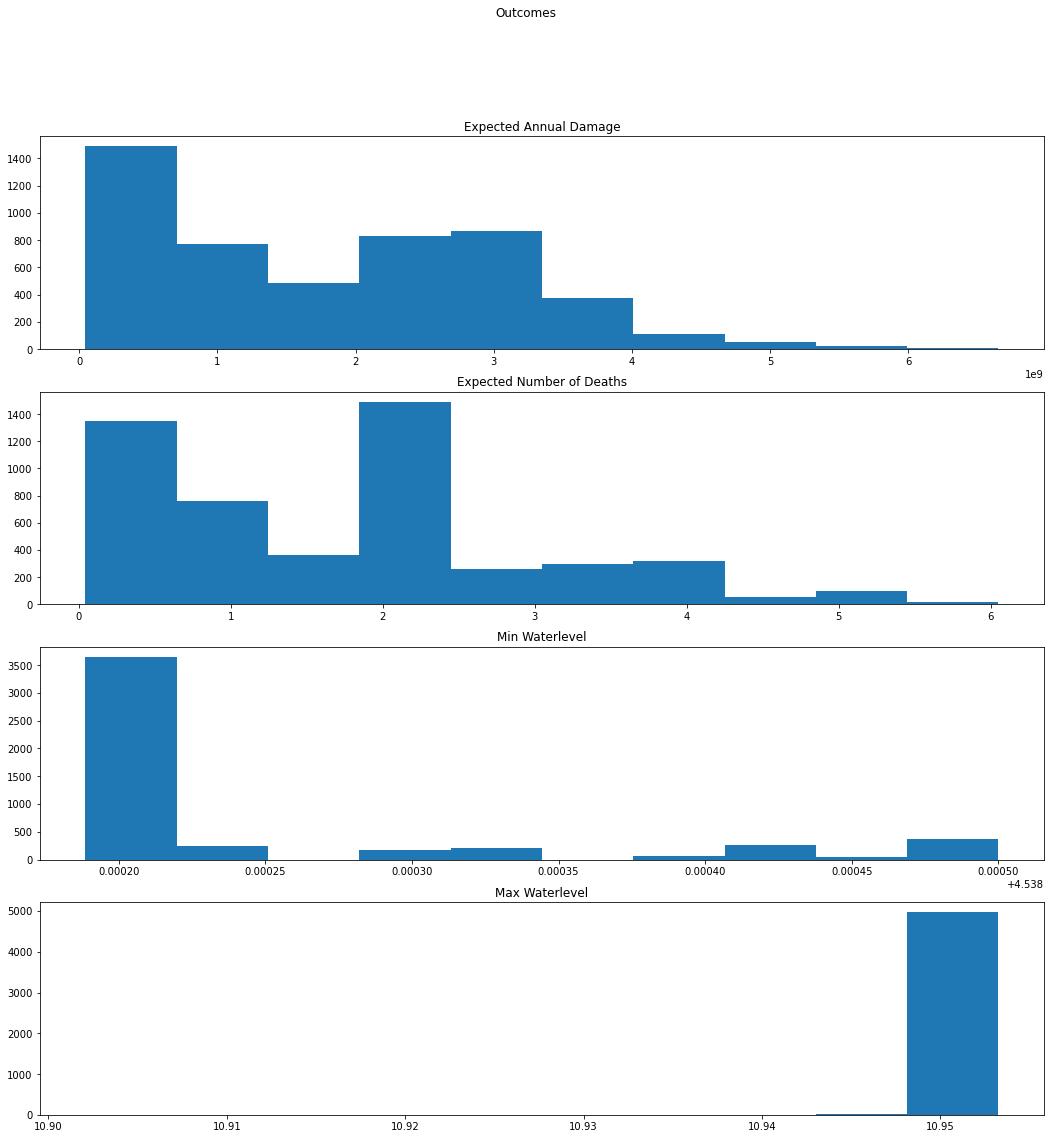

In [10]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1)

fig.suptitle('Outcomes')
fig.set_size_inches(18,18)

ax1.hist(pf2_outcomes['Expected Annual Damage'])
ax1.set_title('Expected Annual Damage')

ax2.hist(pf2_outcomes['Expected Number of Deaths'])
ax2.set_title('Expected Number of Deaths')

ax3.hist(pf2_outcomes['Min Waterlevel'])
ax3.set_title('Min Waterlevel')

ax4.hist(pf2_outcomes['Max Waterlevel'])
ax4.set_title('Max Waterlevel')

plt.show

### Boxplots

Median:  1684490241.1021686
Q1 quantile:  565694050.5974363
Q3 quantile:  2809346224.5996804


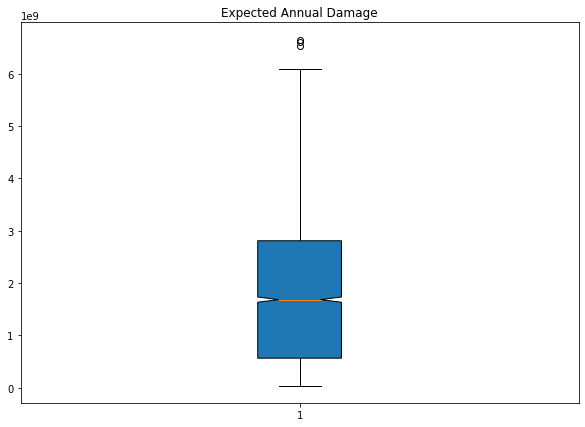

In [11]:
#boxplot for 'Expected Annual Damage'
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(pf2_outcomes['Expected Annual Damage'],  notch=True, patch_artist=True )

print("Median: ", np.quantile(pf2_outcomes['Expected Annual Damage'], .50))
print("Q1 quantile: ", np.quantile(pf2_outcomes['Expected Annual Damage'], .25))
print("Q3 quantile: ", np.quantile(pf2_outcomes['Expected Annual Damage'], .75))

plt.title('Expected Annual Damage')
    

# show plot
plt.show()

Median:  1.891785644426295
Q1 quantile:  0.576957690876557
Q3 quantile:  2.1701178844086337


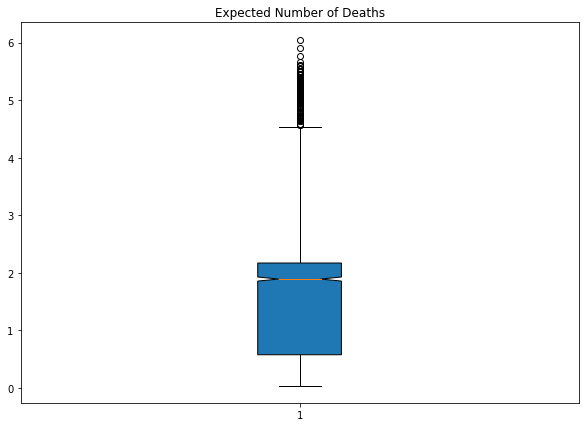

In [12]:
#boxplot for 'Expected Number of Deaths'
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(pf2_outcomes['Expected Number of Deaths'],  notch=True, patch_artist=True )

print("Median: ", np.quantile(pf2_outcomes['Expected Number of Deaths'], .50))
print("Q1 quantile: ", np.quantile(pf2_outcomes['Expected Number of Deaths'], .25))
print("Q3 quantile: ", np.quantile(pf2_outcomes['Expected Number of Deaths'], .75))

plt.title('Expected Number of Deaths')
    

# show plot
plt.show()

Median:  4.538188602702715
Q1 quantile:  4.538188602702715
Q3 quantile:  4.53824000658094


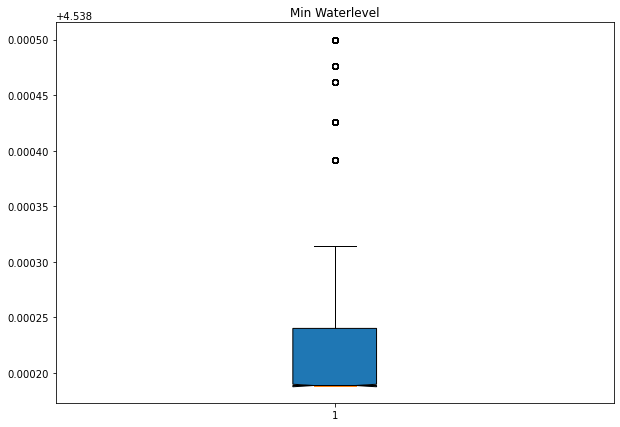

In [13]:
#boxplot for 'Min waterlevel'
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(pf2_outcomes['Min Waterlevel'],  notch=True, patch_artist=True )

print("Median: ", np.quantile(pf2_outcomes['Min Waterlevel'], .50))
print("Q1 quantile: ", np.quantile(pf2_outcomes['Min Waterlevel'], .25))
print("Q3 quantile: ", np.quantile(pf2_outcomes['Min Waterlevel'], .75))

plt.title('Min Waterlevel')
    

# show plot
plt.show()

Median:  10.953253763115368
Q1 quantile:  10.953253763115368
Q3 quantile:  10.953253763115368


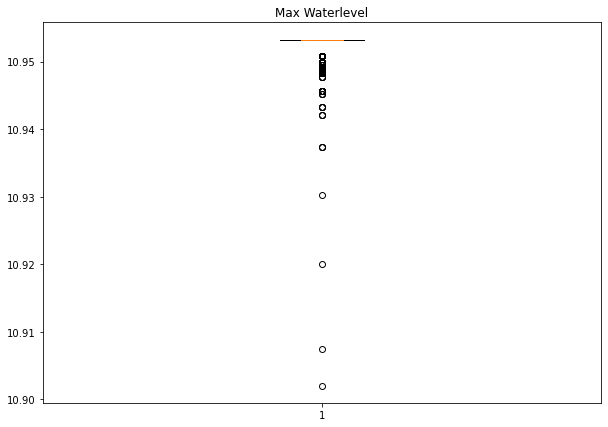

In [14]:
#boxplot for 'Max waterlevel'
fig = plt.figure(figsize =(10, 7))
 
# Creating plot
plt.boxplot(pf2_outcomes['Max Waterlevel'],  notch=True, patch_artist=True )

print("Median: ", np.quantile(pf2_outcomes['Max Waterlevel'], .50))
print("Q1 quantile: ", np.quantile(pf2_outcomes['Max Waterlevel'], .25))
print("Q3 quantile: ", np.quantile(pf2_outcomes['Max Waterlevel'], .75))

plt.title('Max Waterlevel')
    

# show plot
plt.show()

### 3.2. Worst Case Scenario (WCS)

(*Note that this should be run with pf6, as this describes the needed direction of optimalisation*)
The code of the experimental setup for the worst case scenario in pseudo code is: 

```python
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import (MultiprocessingEvaluator, save_results)
from ema_workbench.em_framework.evaluators import perform_experiments

convergence_metrics = [HyperVolume.from_outcomes(dike_model.outcomes),
                       EpsilonProgress()]

random.seed(3922875)
with MultiprocessingEvaluator(dike_model) as evaluator:
    results, convergence = evaluator.optimize(nfe=8500, searchover='uncertainties', 
                                              reference = policy_0, 
                                              epsilons=[0.05, 0.05, 0.05, 0.05], 
                                              convergence=convergence_metrics)

save_results((results, convergence), './results/opt_WCS_results.tar.gz')
```

In [7]:
opt_WCS = load_results('./results/opt_WCS_results.tar.gz')

[MainProcess/INFO] results loaded succesfully from C:\Users\Katherina\Documents\EPA\Q4\Model-based decision-making\final assignment\final assignment\results\opt_WCS_results.tar.gz


In [8]:
opt_WCS_results, opt_WCS_convergence = opt_WCS

In [9]:
opt_WCS_convergence

{'hypervolume': array([0.        , 0.60967882, 0.94516212, 0.69861284, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]),
 'epsilon_progress': array([ 0, 14, 37, 46, 51, 53, 56, 57, 57, 58], dtype=int64),
 'nfe': array([   0,  100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100],
       dtype=int64)}

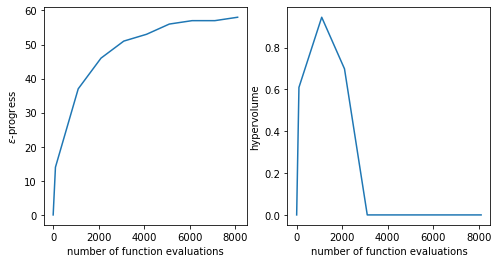

<Figure size 432x288 with 0 Axes>

In [18]:
# figure not saved
# wouldn't recogonize keys for some reason so had to refer to keys in another way
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(opt_WCS_convergence['nfe'], opt_WCS_convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(opt_WCS_convergence['nfe'], opt_WCS_convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()
plt.savefig('./results/opt_WCS_convergence')

In [10]:
# select the columns from the results containing the uncertainties in variable selected
selected = opt_WCS_results.iloc[:,0:19]

In [11]:
# make from the variable selected scenario objects

worst_case_scenarios = [Scenario({index}, **row) for index, row in selected.iterrows()]
## f is function makes dictionary met index key en row value

In [12]:
# then turn them into individual objects by selecting from the worst_case_scenarios
# some scenario inputs are defined as strings with categories, the following code makes them floats
worst_case_scenario_1 = worst_case_scenarios[0]
for key in worst_case_scenario_1:
    #print('original', worst_case_scenario_1[key])
    if type(worst_case_scenario_1[key]) == str:
            value = worst_case_scenario_1[key]
            real_value = float(value[-4:-1])
            #print('for', worst_case_scenario_1[key], 'real_value is', real_value)
            worst_case_scenario_1[key]=real_value
worst_case_scenario_2 = worst_case_scenarios[1]
for key in worst_case_scenario_2:
    #print('original', worst_case_scenario_2[key])
    if type(worst_case_scenario_2[key]) == str:
            value = worst_case_scenario_2[key]
            real_value = float(value[-4:-1])
            #print('for', worst_case_scenario_2[key], 'real_value is', real_value)
            worst_case_scenario_2[key]=real_value

In [13]:
# policies for each project, given that they are maintained for all 3 time plannings
#base case
base_case = Policy("no release", **{l.name:0 for l in dike_model.levers})
#first project
project_0 = Policy( **{l.name:0 for l in dike_model.levers})
project_0['0_RfR 0'] = 1
project_0['0_RfR 1'] = 1
project_0['0_RfR 2'] = 1
#2nd project
project_1 = Policy( **{l.name:0 for l in dike_model.levers})
project_1['1_RfR 0'] = 1
project_1['1_RfR 1'] = 1
project_1['1_RfR 2'] = 1
#3rd project
project_2 = Policy( **{l.name:0 for l in dike_model.levers})
project_2['2_RfR 0'] = 1
project_2['2_RfR 1'] = 1
project_2['2_RfR 2'] = 1
#4th project
project_3 = Policy( **{l.name:0 for l in dike_model.levers})
project_3['3_RfR 0'] = 1
project_3['3_RfR 1'] = 1
project_3['3_RfR 2'] = 1
#5th project
project_4 = Policy( **{l.name:0 for l in dike_model.levers})
project_4['4_RfR 0'] = 1
project_4['4_RfR 1'] = 1
project_4['4_RfR 2'] = 1
#A.1 dike increase
A_1_DikeIncrease = Policy( **{l.name:0 for l in dike_model.levers})
A_1_DikeIncrease['A.1_DikeIncrease 0'] = 1
A_1_DikeIncrease['A.1_DikeIncrease 1'] = 1
A_1_DikeIncrease['A.1_DikeIncrease 2'] = 1
#A.2 dike increase
A_2_DikeIncrease = Policy( **{l.name:0 for l in dike_model.levers})
A_2_DikeIncrease['A.2_DikeIncrease 0'] = 1
A_2_DikeIncrease['A.2_DikeIncrease 1'] = 1
A_2_DikeIncrease['A.2_DikeIncrease 2'] = 1
#A.3 dike increase
A_3_DikeIncrease = Policy( **{l.name:0 for l in dike_model.levers})
A_3_DikeIncrease['A.3_DikeIncrease 0'] = 1
A_3_DikeIncrease['A.3_DikeIncrease 1'] = 1
A_3_DikeIncrease['A.3_DikeIncrease 2'] = 1
#A.4 dike increase
A_4_DikeIncrease = Policy( **{l.name:0 for l in dike_model.levers})
A_4_DikeIncrease['A.4_DikeIncrease 0'] = 1
A_4_DikeIncrease['A.4_DikeIncrease 1'] = 1
A_4_DikeIncrease['A.4_DikeIncrease 2'] = 1
#A.5 dike increase
A_5_DikeIncrease = Policy( **{l.name:0 for l in dike_model.levers})
A_5_DikeIncrease['A.5_DikeIncrease 0'] = 1
A_5_DikeIncrease['A.5_DikeIncrease 1'] = 1
A_5_DikeIncrease['A.5_DikeIncrease 2'] = 1

In [14]:
policies = [base_case, project_0, project_1, project_2, project_3, project_4, 
            A_1_DikeIncrease, A_2_DikeIncrease, A_3_DikeIncrease, A_4_DikeIncrease, A_5_DikeIncrease ]

In [15]:
# run with pf 2
# results are not saved but it take less than 5min to run this
random.seed(3922875)
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(worst_case_scenario_1, policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 11 policies * 1 model(s) = 11 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 11 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [16]:
experiments, outcomes_solution1 = results

In [17]:
outcomes_solution1

{'Expected Annual Damage': array([5.78879370e+09, 5.63653647e+09, 5.62982494e+09, 3.85530313e+09,
        4.30416848e+09, 5.54824613e+09, 5.78789612e+09, 5.46854402e+09,
        4.44407604e+09, 5.78441084e+09, 5.78879370e+09]),
 'Dike Investment Costs': array([        0,         0,         0,         0,         0,         0,
        101474517, 118700628,  63002497,  19617742,  77707505]),
 'RfR Investment Costs': array([0.000e+00, 2.538e+08, 6.534e+08, 9.210e+07, 3.636e+08, 7.683e+08,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 'Expected Number of Deaths': array([5.43545233, 5.35678776, 5.34432893, 2.63899269, 3.36157377,
        5.05579846, 5.43485825, 5.26739551, 3.35131414, 5.43468747,
        5.43545233]),
 'Min Waterlevel': array([4.5385, 4.5385, 4.5385, 4.5385, 4.1785, 4.5385, 4.5385, 4.5385,
        4.5385, 4.1785, 4.5385]),
 'Max Waterlevel': array([10.95120095, 10.38120095, 10.44120095, 10.95120095, 10.95120095,
        10.95120095, 10.95120095, 10.951200

In [18]:
# run with pf 2
# results are not saved but it take less than 5min to run this
random.seed(3922880)
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(worst_case_scenario_2, policies)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1 scenarios * 11 policies * 1 model(s) = 11 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 11 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [19]:
experiments, outcomes_solution2 = results

In [20]:
outcomes_solution2

{'Expected Annual Damage': array([7.33823150e+09, 4.30057144e+09, 4.30853914e+09, 5.44331768e+09,
        6.33550942e+09, 7.31585487e+09, 6.70575980e+09, 7.17774938e+09,
        6.04838886e+09, 7.33823150e+09, 7.33823150e+09]),
 'Dike Investment Costs': array([        0,         0,         0,         0,         0,         0,
        101474517, 118700628,  63002497,  19617742,  77707505]),
 'RfR Investment Costs': array([0.000e+00, 2.538e+08, 6.534e+08, 9.210e+07, 3.636e+08, 7.683e+08,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 'Expected Number of Deaths': array([5.45974658, 4.04326699, 4.0470489 , 3.0494873 , 4.26124699,
        5.41336895, 5.17325076, 5.39342961, 3.85294528, 5.45974658,
        5.45974658]),
 'Min Waterlevel': array([4.5385, 4.5385, 4.5385, 4.5385, 4.1785, 4.5385, 4.5385, 4.5385,
        4.1785, 4.5385, 4.5385]),
 'Max Waterlevel': array([10.94416833, 10.37416833, 10.43416833, 10.94416833, 10.94416833,
        10.94416833, 10.94416833, 10.944168

## 4. Vulnerability Analysis
In this part of the notebook, the uncertainty and levers that most influence the studied outcomes are identified using vulnerability analysis. This analysis is performed by means of a sensitivity analysis (4.1) and a scenario discovery (4.2).

### 4.1. Sensitivity Analysis: Extra Trees

In [7]:
BC_aggregated_experiments, BC_aggregated_outcomes = load_results('./results/base_exploration_aggregated.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/hillaryiseniabustamante/Desktop/epa1361_open-master 2/final assignment/results/base_exploration_aggregated.tar.gz


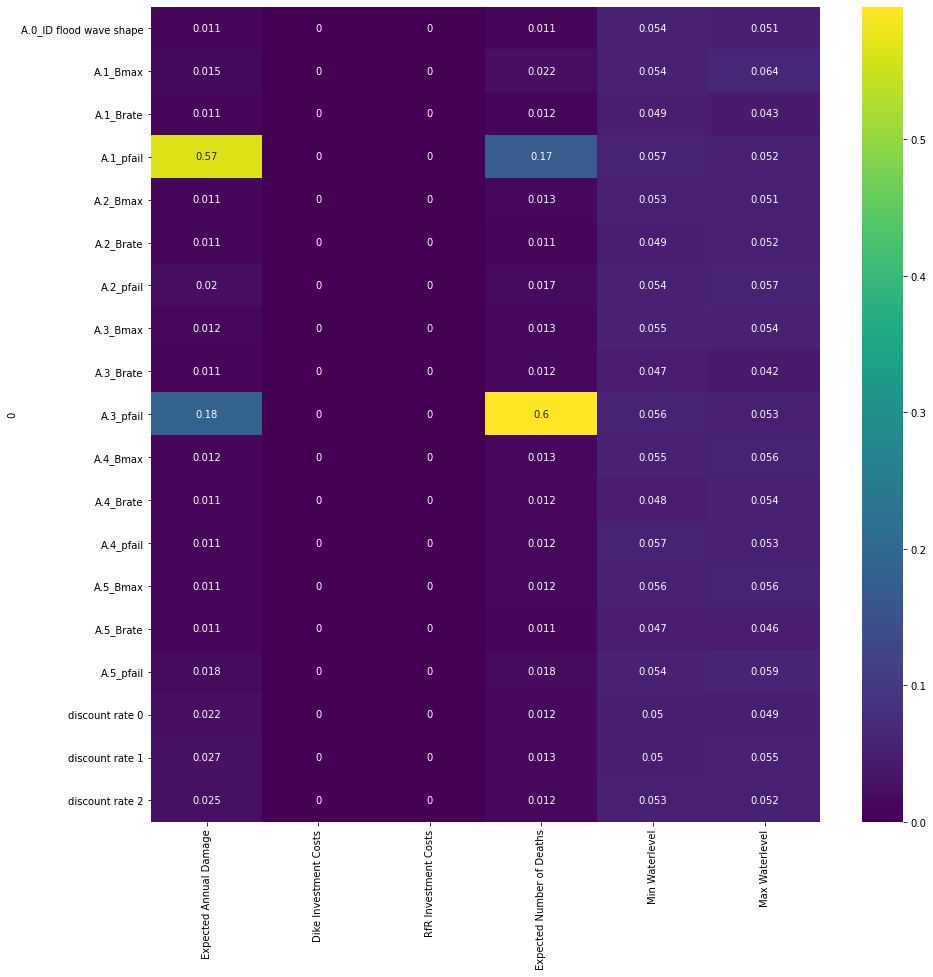

In [8]:
# on open explortion dataset:
x = BC_aggregated_experiments.iloc[:,:19]
y = BC_aggregated_outcomes
fig = plt.figure(figsize =(15, 15))
fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap='viridis', annot=True)

plt.show()

In [21]:
#validate with different random.seed experiments
def extra_trees (seed):
    random.seed(seed)
    with MultiprocessingEvaluator(dike_model) as evaluator:
        results = evaluator.perform_experiments(scenarios=1000, policies=policy_0)
    experiments, outcomes = results
    cleaned_experiments = experiments.drop(columns=[l.name for l in dike_model.levers])
    for outcome in outcomes: #aanpassen op uitkomsten dict
        outcome_list = outcomes[outcome] #aanpassen op uitkomsten dict
        scores = feature_scoring.get_ex_feature_scores(cleaned_experiments, outcome_list, nr_trees = 1000, max_features=0.6, mode=RuleInductionType.REGRESSION)
        if outcome == 'Expected Annual Damage': #niet nodig
            Damage_scores = scores #niet nodig
            Damage_scores = Damage_scores[0]
            EAD = Damage_scores.T
            EAD = EAD.rename(index={1: 'Expected Annual Damage'})
        elif outcome == 'Min Waterlevel':
            Min_waterscores = scores
            Min_waterscores = Min_waterscores[0]
            MINW = Min_waterscores.T
            MINW = MINW.rename(index={1: 'Min Waterlevel'})
        elif outcome == 'Max Waterlevel': 
            Max_waterscores = scores
            Max_waterscores = Max_waterscores[0]
            MAXW = Max_waterscores.T
            MAXW = MAXW.rename(index={1: 'Max Waterlevel'})
        elif outcome == 'Expected Number of Deaths': 
            Death_scores = scores #niet nodig
            Death_scores = Death_scores[0]
            END = Death_scores.T
            END = END.rename(index={1: 'Expected Number of Deaths'})
    fs_sa = END.append(EAD)
    fs_sa = fs_sa.append(MINW)
    fs_sa = fs_sa.append(MAXW)
    fig = plt.figure(figsize =(18, 10))

    sns.heatmap(fs_sa.T, cmap='viridis', annot=True)

    plt.show()
    return fs_sa

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO]

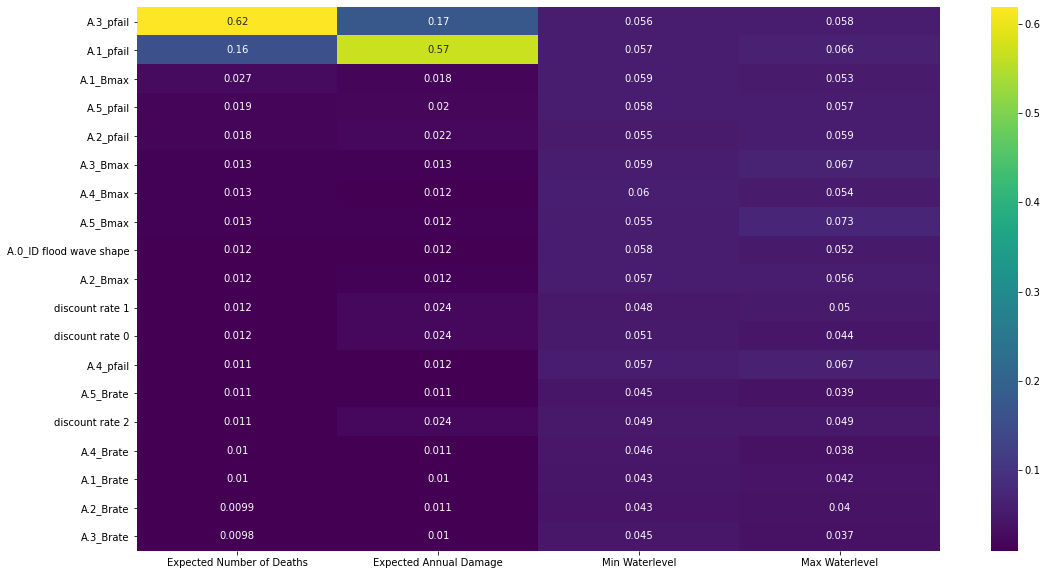

In [22]:
# results not saved, rerun at own risk
fs_sa_3922875 = extra_trees (3922875)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO]

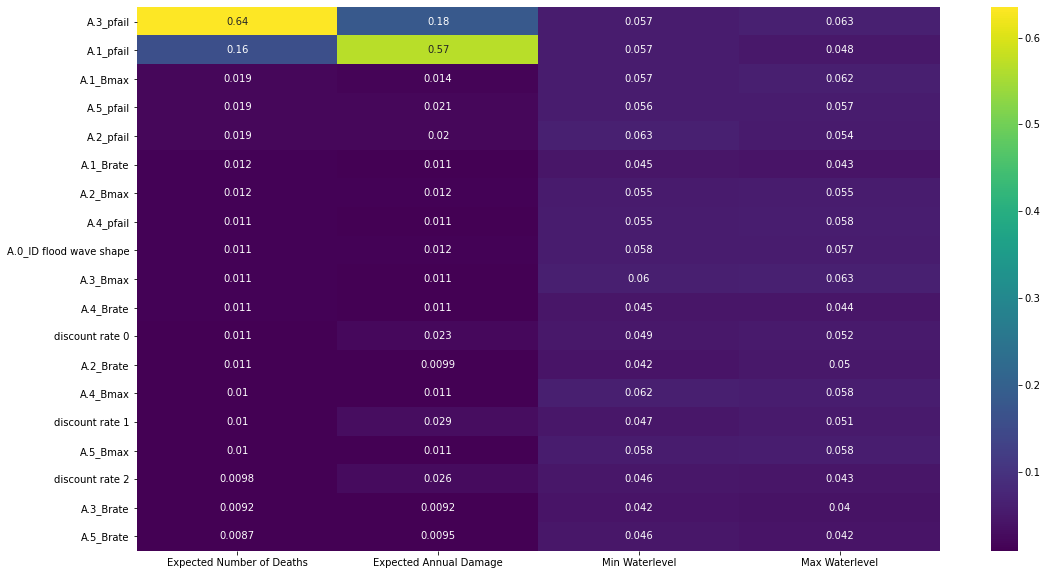

In [23]:
# results not saved, rerun at own risk
fs_sa_3922876 = extra_trees (3922876)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO]

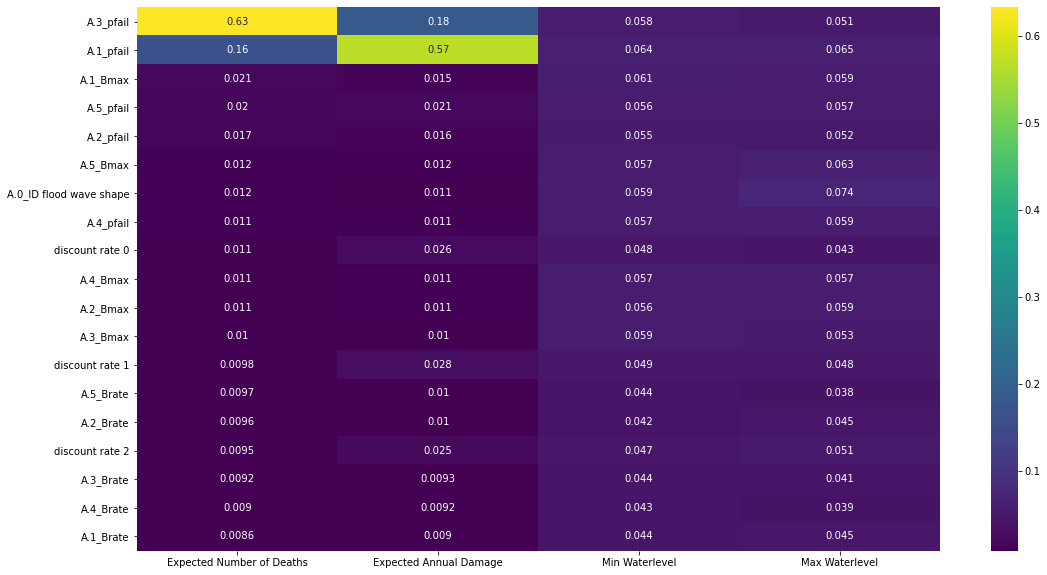

In [24]:
# results not saved, rerun at own risk
fs_sa_3922877 = extra_trees (3922877)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] policy dropped from analysis because only a single category
[MainProcess/INFO]

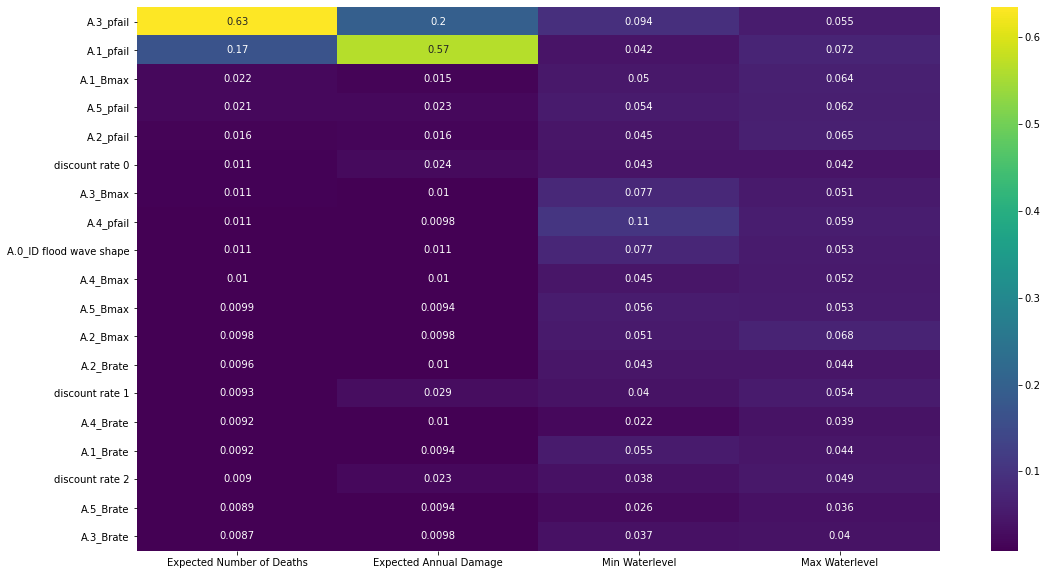

In [25]:
# results not saved, rerun at own risk
fs_sa_8888888 = extra_trees (8888888)

### 4.2. Scenario Discovery: PRIM

The code of the experimental setup for the scenario discovery in pseudo code is:

```python
from ema_workbench import (MultiprocessingEvaluator, save_results)
from ema_workbench.em_framework.evaluators import perform_experiments

random.seed(3922875)
n_scenarios = 2000

with MultiprocessingEvaluator(dike_model) as evaluator: 
    pf2_SD_results = evaluator.perform_experiments(n_scenarios, policies=5)

save_results((pf2_SD_results), './results/pf2_SD_results.tar.gz')
```

In [37]:
Dike_Investment_Costs = pd.read_csv("./results/pf2_SD_results_csv/Dike Investment Costs.csv", header = None, names = ["Dike_Investment_Costs"])

Expected_Annual_Damage = pd.read_csv("results/pf2_SD_results_csv/Expected Annual Damage.csv", header = None, names = ["Annual_Damage"])

Expected_Number_Deaths = pd.read_csv("results/pf2_SD_results_csv/Expected Number of Deaths.csv", header = None, names = ["Number_of_Deaths"])

RfR_Investment_Costs = pd.read_csv("results/pf2_SD_results_csv/RfR Investment Costs.csv", header = None, names = ["RfR_Investment_Costs"])

Max_Waterlevel = pd.read_csv("results/pf2_SD_results_csv/Max Waterlevel.csv", header = None, names = ["Max_Waterlevel"])

Min_Waterlevel = pd.read_csv("results/pf2_SD_results_csv/Min Waterlevel.csv", header = None, names = ["Min_Waterlevel"])

Experiments =  pd.read_csv("results/pf2_SD_results_csv/experiments.csv")

In [38]:
cleaned_experiments= Experiments.drop(labels=[l.name for l in dike_model.levers], axis=1)

,A.0_ID flood wave shape,A.1_Bmax,A.1_Brate,A.1_pfail,A.2_Bmax,A.2_Brate,A.2_pfail,A.3_Bmax,A.3_Brate,A.3_pfail,...,A.4_pfail,A.5_Bmax,A.5_Brate,A.5_pfail,discount rate 0,discount rate 1,discount rate 2,scenario,policy,model
0,78.0,273.400477,1.0,0.054174,283.539013,1.5,0.529175,109.665003,10.0,0.576600,...,0.172583,265.295845,1.5,0.994089,1.5,1.5,1.5,0,0,dikesnet
1,36.0,230.601974,1.0,0.384890,195.222668,1.0,0.440984,318.837797,10.0,0.671492,...,0.995135,236.714858,10.0,0.778226,4.5,1.5,4.5,1,0,dikesnet
2,42.0,300.731997,1.0,0.753359,152.784708,1.5,0.961431,64.413738,10.0,0.092116,...,0.017292,233.584312,1.5,0.340271,2.5,3.5,4.5,2,0,dikesnet
3,115.0,166.837231,10.0,0.653734,42.377809,10.0,0.948232,261.786107,1.0,0.067494,...,0.214001,201.636202,1.5,0.499946,1.5,1.5,2.5,3,0,dikesnet
4,18.0,202.527814,1.0,0.181933,284.391412,1.5,0.808903,37.295469,10.0,0.118427,...,0.124918,307.219433,10.0,0.494559,4.5,2.5,4.5,4,0,dikesnet


In [39]:
Dike_Investment_Costs['Constraints']= Dike_Investment_Costs.Dike_Investment_Costs.apply(lambda x:1 if x <= Dike_Investment_Costs["Dike_Investment_Costs"].mean() else 0)

Expected_Annual_Damage['Constraints']= Expected_Annual_Damage.Annual_Damage.apply(lambda x:1 if x <= Expected_Annual_Damage["Annual_Damage"].median() else 0)

Expected_Number_Deaths['Constraints']= Expected_Number_Deaths.Number_of_Deaths.apply(lambda x:1 if x <= Expected_Number_Deaths["Number_of_Deaths"].mean() else 0)

RfR_Investment_Costs['Constraints']= RfR_Investment_Costs.RfR_Investment_Costs.apply(lambda x:1 if x <= RfR_Investment_Costs["RfR_Investment_Costs"].mean() else 0)

Max_Waterlevel['Constraints']= Max_Waterlevel.Max_Waterlevel.apply(lambda x:1 if x <= Max_Waterlevel["Max_Waterlevel"].mean() else 0)

Min_Waterlevel['Constraints']= Min_Waterlevel.Min_Waterlevel.apply(lambda x:1 if x >= Min_Waterlevel["Min_Waterlevel"].mean() else 0)

In [40]:
Dike_Investment_Costs_Constraints = Dike_Investment_Costs.iloc[:,1]

Expected_Annual_Damage_Constraints = Expected_Annual_Damage.iloc[:,1]

Expected_Number_Deaths_Constraints = Expected_Number_Deaths.iloc[:,1]

RfR_Investment_Costs_Constraints = RfR_Investment_Costs.iloc[:,1]

Max_Waterlevel_Constraints = Max_Waterlevel.iloc[:,1]

Min_Waterlevel_Constraints = Min_Waterlevel.iloc[:,1]

In [41]:
def apply_prim(box_number, y = Expected_Annual_Damage, threshold = 0.8, peel_alpha=0.05):
    prim_alg = prim.Prim(x = cleaned_experiments, y=y, threshold=threshold, peel_alpha=peel_alpha)
    box = prim_alg.find_box() 
    
    #Visualize the trade off between coverage and density
    box.show_tradeoff()
    plot1 = plt.show()
    plot2 = box.inspect(style='graph')
    plot2.set_size_inches(18,18)
    
    #Plot the point of box in a pairs_scatter plot
    box.select(box_number)
    fig = box.show_pairs_scatter()
    plot3 = plt.show()
    return (plot1, plot2) # plot3)

### Dike investment costs

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 4000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4, coverage: 1.0, density: 1.0 restricted_dimensions: 1


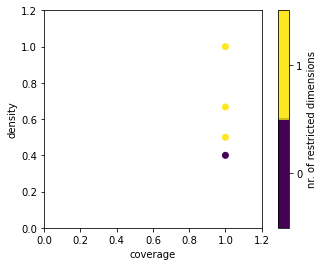

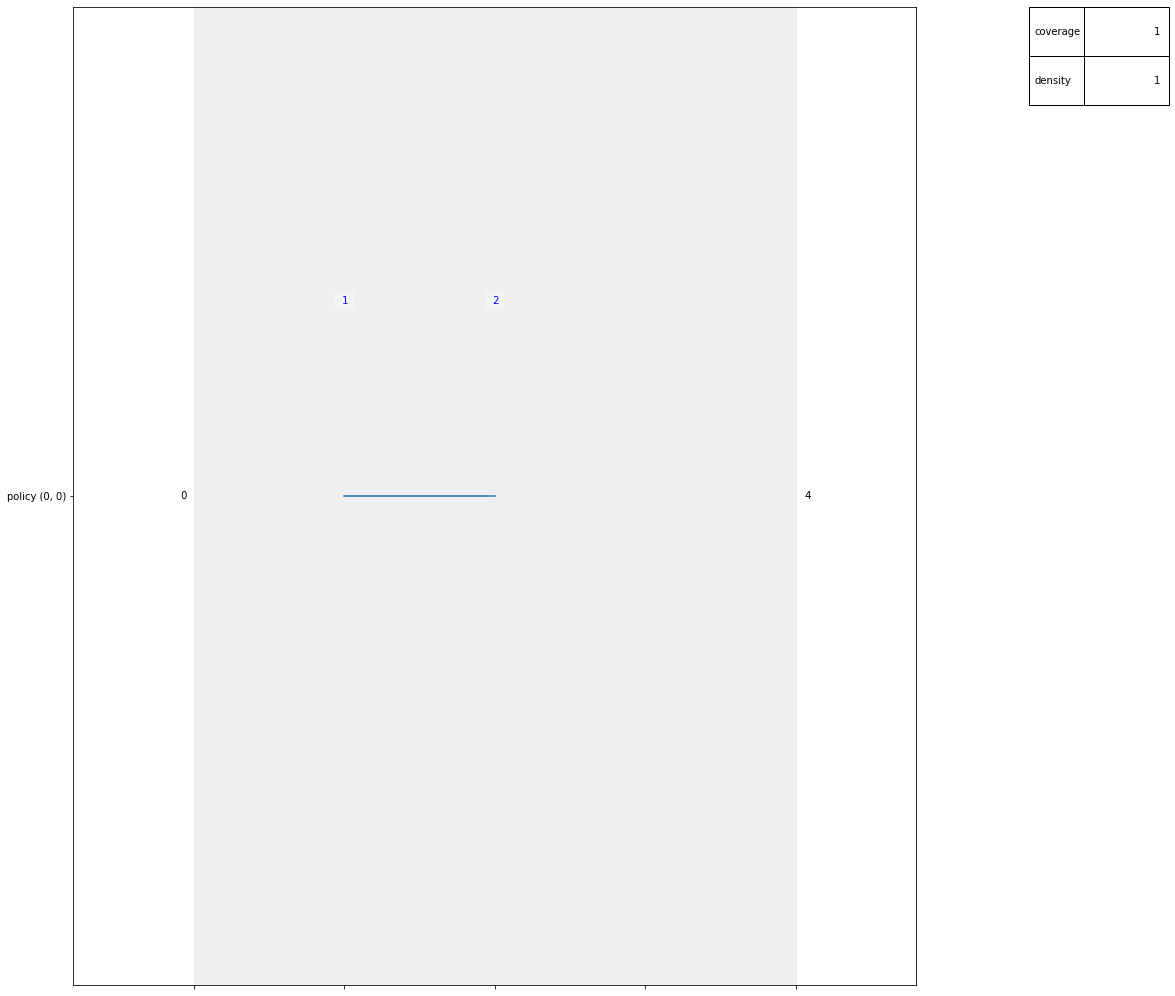

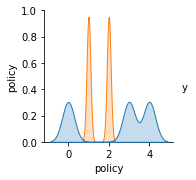

(None, <Figure size 1296x1296 with 1 Axes>)

In [42]:
apply_prim(1, y = Dike_Investment_Costs_Constraints, threshold = 0.4)

### Expected Annual Damage

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 5000 cases of interest
[MainProcess/INFO] mean: 0.9, mass: 0.051, coverage: 0.0918, density: 0.9 restricted_dimensions: 8


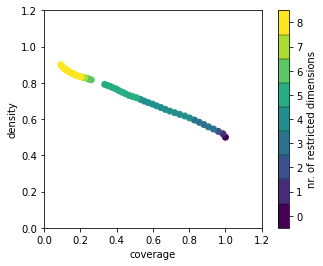

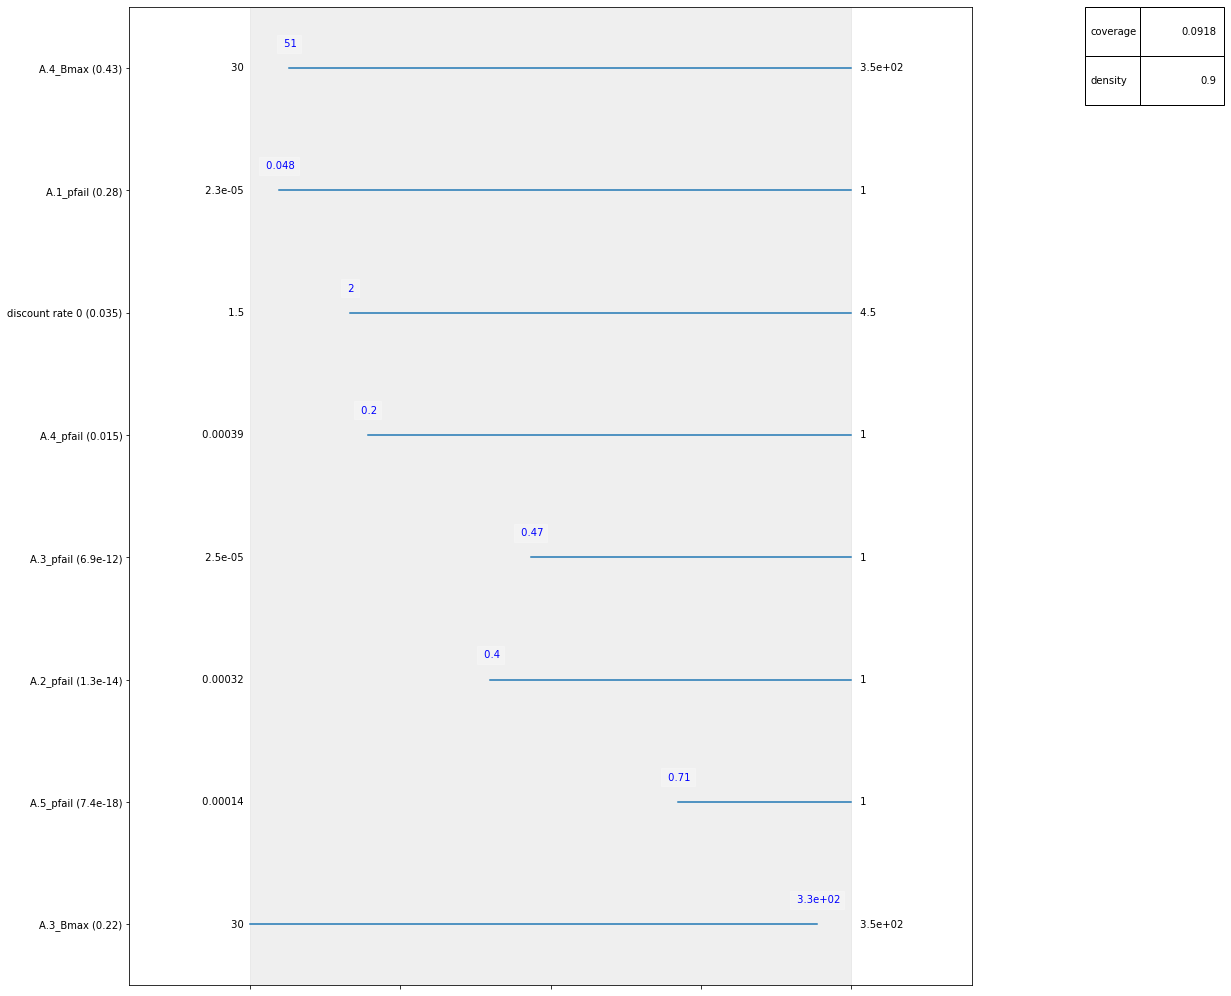

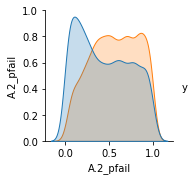

(None, <Figure size 1296x1296 with 1 Axes>)

In [43]:
apply_prim(1, y = Expected_Annual_Damage_Constraints, threshold = 0.8)

### Expected Number Deaths Constraints

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 7900 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.072, coverage: 0.09113924050632911, density: 1.0 restricted_dimensions: 9


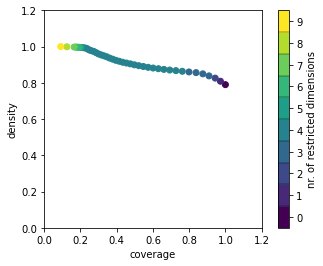

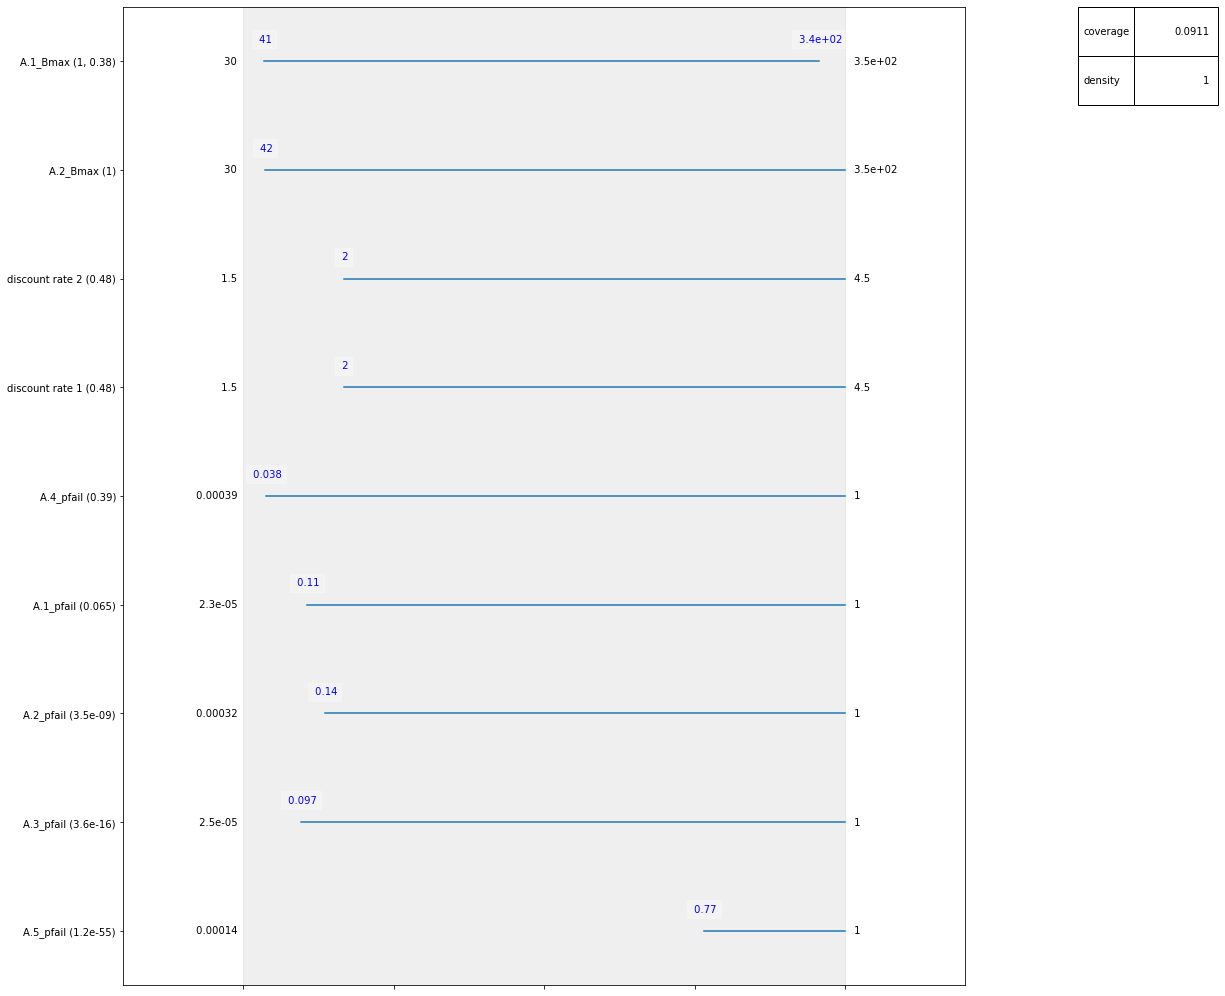

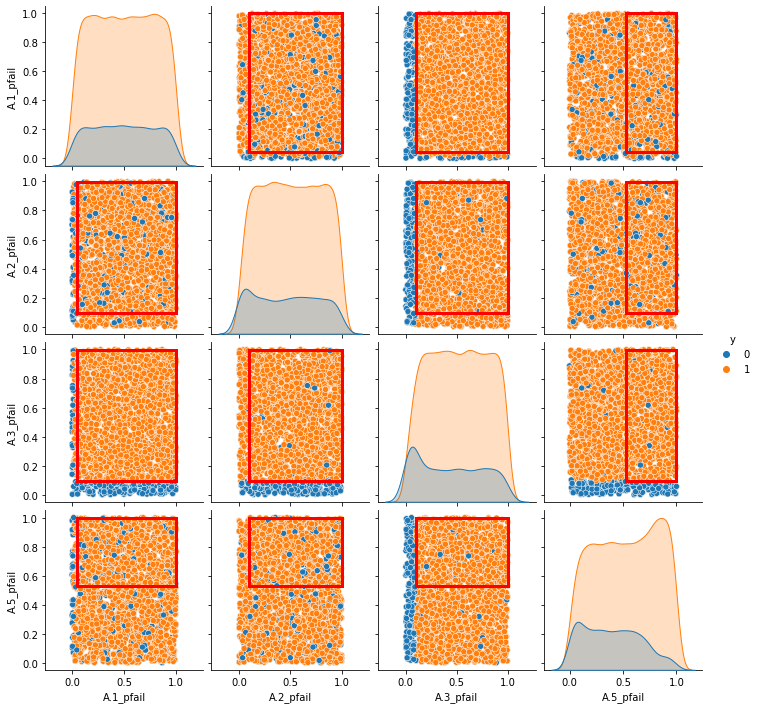

(None, <Figure size 1296x1296 with 1 Axes>)

In [44]:
apply_prim(20, y =Expected_Number_Deaths_Constraints , threshold = 0.8)

### RfR Investment Costs

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 4000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4, coverage: 1.0, density: 1.0 restricted_dimensions: 1


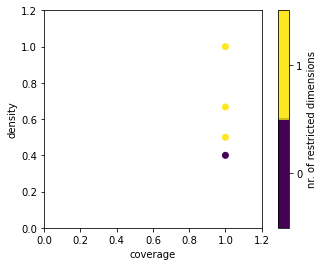

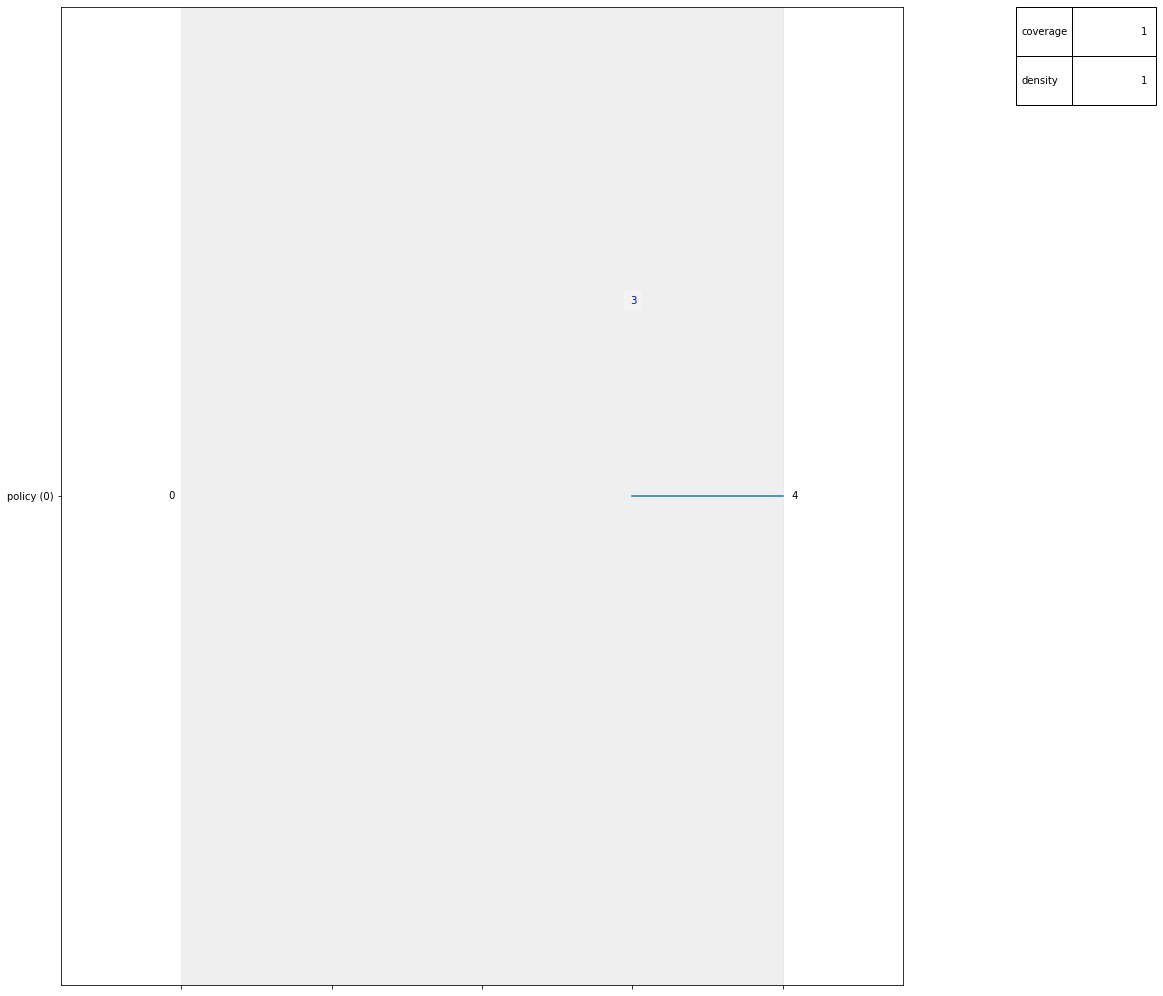

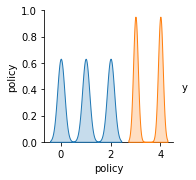

(None, <Figure size 1296x1296 with 1 Axes>)

In [45]:
apply_prim(1, y =RfR_Investment_Costs_Constraints , threshold = 0.8)

### Max Waterlevel

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 6059 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.6, coverage: 0.9902624195411784, density: 1.0 restricted_dimensions: 1


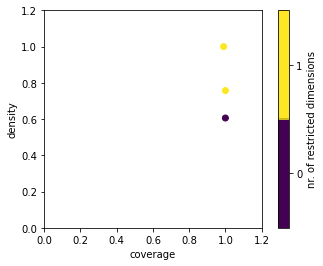

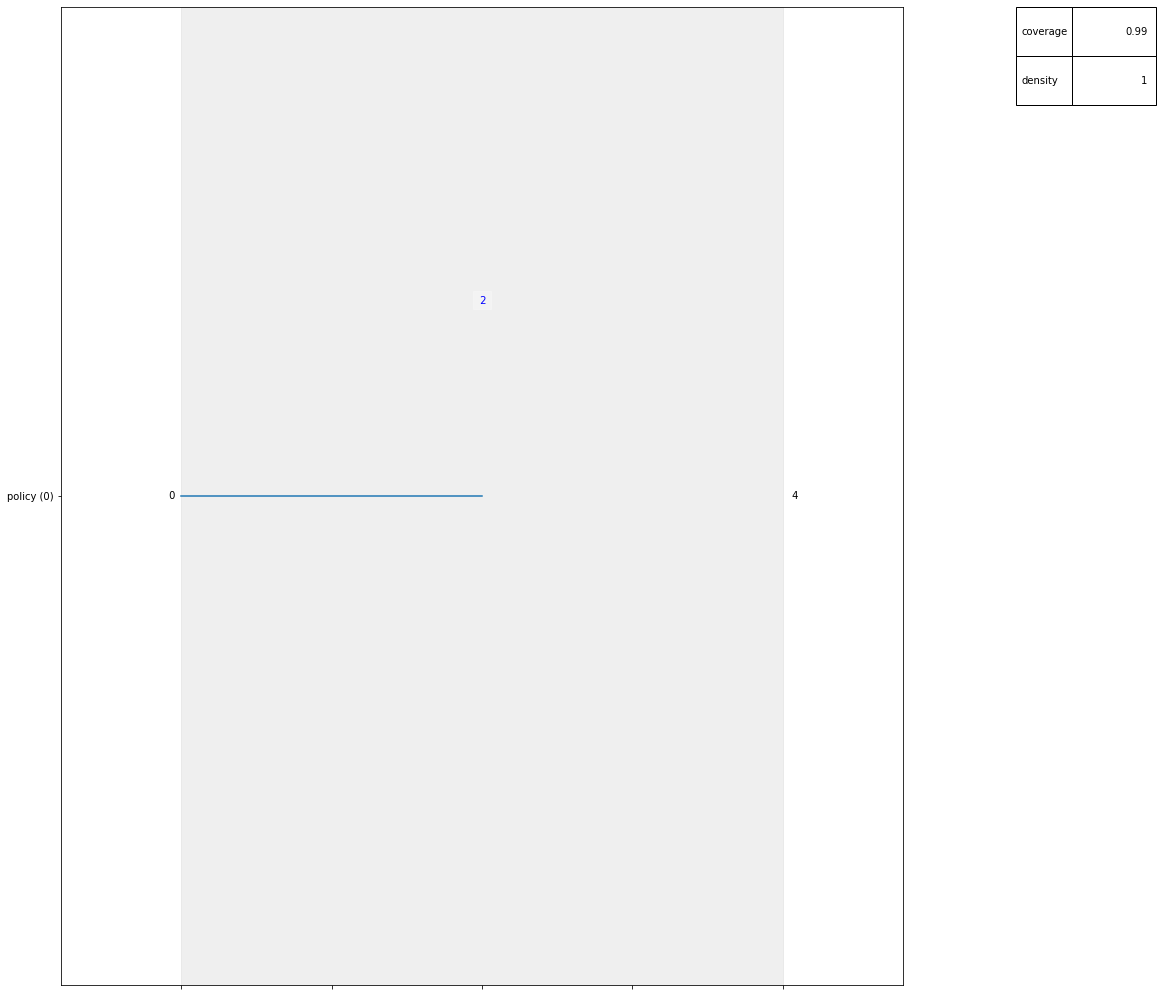

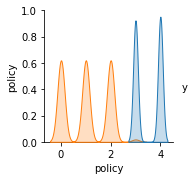

(None, <Figure size 1296x1296 with 1 Axes>)

In [46]:
apply_prim(1, y =Max_Waterlevel_Constraints, threshold = 0.8)

### Min Waterlevel

[MainProcess/INFO] model dropped from analysis because only a single category
[MainProcess/INFO] 10000 points remaining, containing 4000 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.4, coverage: 1.0, density: 1.0 restricted_dimensions: 1


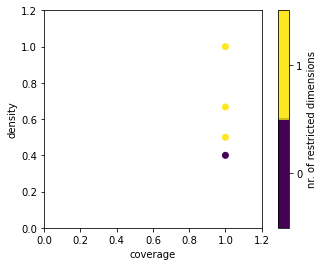

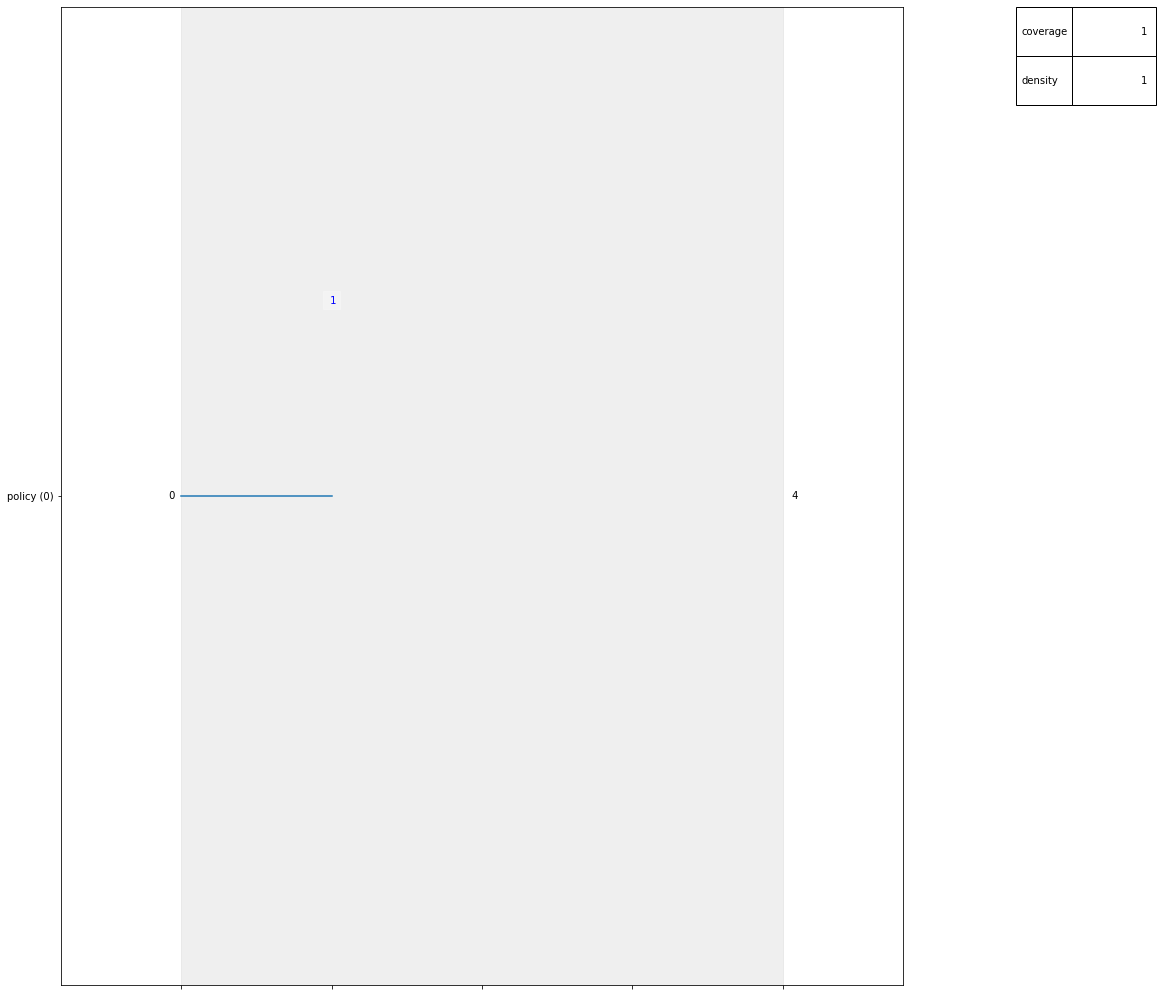

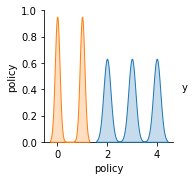

(None, <Figure size 1296x1296 with 1 Axes>)

In [47]:
apply_prim(1, y =Min_Waterlevel_Constraints, threshold = 0.8)

### Define Scenarios for MORO

In [48]:
#generate random scenarios, in order to later change the values the scenario discovery pointed to
random.seed(3922875)
n_scenarios = 6
RO_scenarios = sample_uncertainties(dike_model, n_scenarios)

In [49]:
dic_AD_min = {'A.4_Bmax': 51, 'A.1_pfail': 0.048, 'discount rate 0': 2, 'A.4_pfail': 0.2, 'A.3_pfail': 0.47,
         'A.2_pfail': 0.4, 'A.5_pfail': 0.71, 'A.3_Bmax': 30}
dic_AD_max = {'A.4_Bmax': 350, 'A.1_pfail': 1, 'discount rate 0': 4.5, 'A.4_pfail': 1, 'A.3_pfail': 1,
         'A.2_pfail': 1, 'A.5_pfail': 1 , 'A.3_Bmax': 330}
dic_ND_min = {'A.1_Bmax': 41, 'A.2_Bmax': 42, 'discount rate 2': 2, 'discount rate 1': 2, 'A.4_pfail': 0.038, 
             'A.1_pfail': 0.11, 'A.2_pfail': 0.14, 'A.3_pfail': 0.097, 'A.5_pfail': 0.77}
dic_ND_max = {'A.1_Bmax': 340, 'A.2_Bmax': 350, 'discount rate 2': 4.5, 'discount rate 1': 4.5, 'A.4_pfail': 1, 
             'A.1_pfail': 1, 'A.2_pfail': 1, 'A.3_pfail': 1, 'A.5_pfail': 1}

In [50]:
scenario_list = [dic_AD_min, dic_AD_max, dic_ND_min, dic_ND_max]

In [51]:
# to add worst case scenarios
scenario_list = [dic_AD_min, dic_AD_max, dic_ND_min, dic_ND_max]
for scenario in worst_case_scenarios:
    dic = {}
    for key in scenario:
        if type(scenario[key]) == str:
            value = scenario[key]
            real_value = float(value[-4:-1])
        else:
            real_value = scenario[key]
        dic[key] = real_value
    scenario_list.append(dic)    
    

In [52]:
# run in order to change values of each excisting scenario in RO_scenarios
i = 0
for scenario in RO_scenarios:
    dic = scenario_list[i]
    for key in dic:
        scenario[str(key)] = dic[key]
    i = i+1

## 5. Multi-Objective Robust Optimization (MORO)
In this part of the notebook, the candidate policy alternatives are identified using MORO.

In [54]:
# Under certain threshold: robust or not 
def robustness(direction, threshold, data):
    if direction == SMALLER:
        return np.sum(data<=threshold)/data.shape[0]
    else:
        return np.sum(data>=threshold)/data.shape[0]

SMALLER = 'SMALLER'
LARGER = 'LARGER'


RfR_Investment_Costs = functools.partial(robustness, SMALLER, 5.4e+8)
Dike_Investment_Costs = functools.partial(robustness, SMALLER, 5.4e+8)
Min_Waterlevel = functools.partial(robustness, LARGER, 4)
Max_Waterlevel = functools.partial(robustness, SMALLER, 6)
Expected_Number_of_Deaths = functools.partial(robustness, SMALLER, 1) 
Expected_Annual_Damage = functools.partial(robustness, SMALLER, 3000000) 

The code of the experimental setup for the robustness converges in pseudo code is:

```python
from ema_workbench import (MultiprocessingEvaluator, save_results)
from ema_workbench.em_framework.evaluators import perform_experiments

random.seed(3922875)
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=500,               
                                            policies=4, uncertainty_sampling='mc')

save_results((results), './results/pf2_experiments.tar.gz')
```

In [55]:
MORO_results = load_results('./results/pf2_experiments.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/hillaryiseniabustamante/Desktop/epa1361_open-master 2/final assignment/results/pf2_experiments.tar.gz


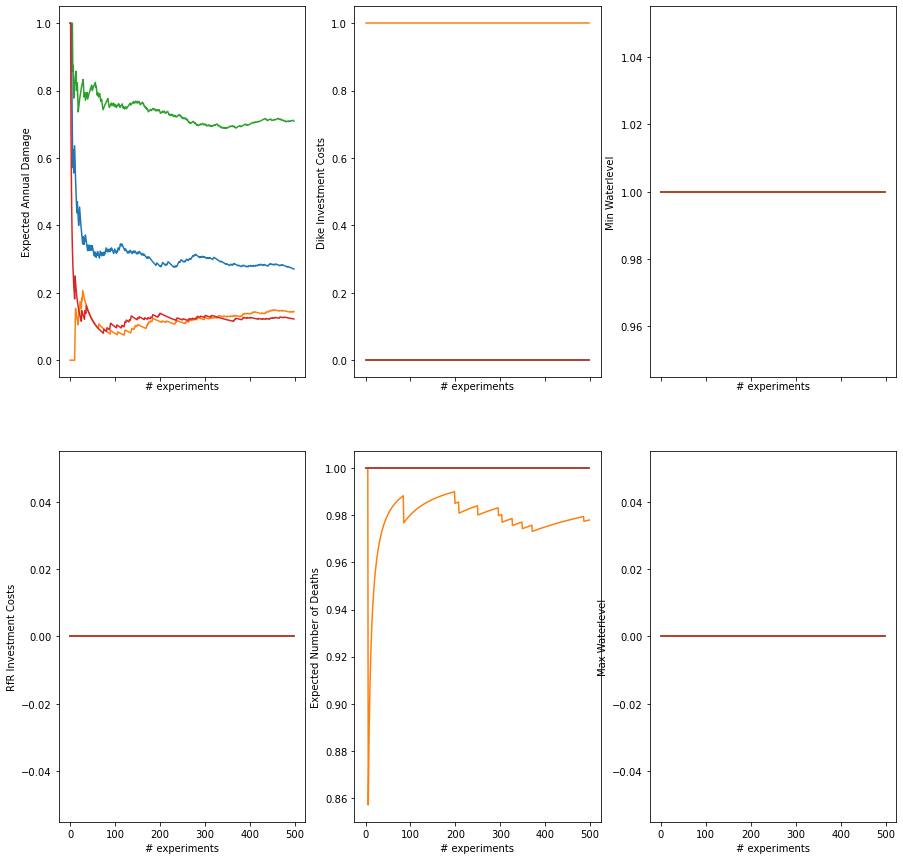

In [56]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(15,15),
                        sharex=True)
axes = [axes[0,0],axes[0,1],axes[1,0],axes[1,1], axes[0,2], axes[1,2]]                             #axes[1,1]

robustness_funcs = {'Expected Number of Deaths': Expected_Number_of_Deaths,
                    'Expected Annual Damage': Expected_Annual_Damage,
                    'Dike Investment Costs' : Dike_Investment_Costs,
                    'RfR Investment Costs' : RfR_Investment_Costs,
                    'Min Waterlevel' : Min_Waterlevel,
                    'Max Waterlevel': Max_Waterlevel}

experiments, outcomes = MORO_results

for ax, (outcome, value) in zip(axes, outcomes.items()):
    for policy in np.unique(experiments['policy']):
        logical = experiments['policy'] == policy
        data = value[logical]
        
        robustness = []
        #print(outcome)
        for i in range(1, data.shape[0]):
            robustness.append(robustness_funcs[outcome](data[0:i]))
            #print(data)
        ax.plot(robustness, label=policy)
    ax.set_xlabel("# experiments")
    ax.set_ylabel(outcome)

In [57]:
MAXIMIZE = ScalarOutcome.MAXIMIZE
MINIMIZE = ScalarOutcome.MINIMIZE

robustnes_functions = [ScalarOutcome('fraction EA deaths', kind=MINIMIZE, 
                             variable_name='Expected Number of Deaths', function=Expected_Number_of_Deaths),
                       ScalarOutcome('fraction EA damage', kind=MINIMIZE, 
                             variable_name='Expected Annual Damage', function=Expected_Annual_Damage),
                       ScalarOutcome('fraction DIC', kind = MINIMIZE, 
                             variable_name='Dike Investment Costs', function = Dike_Investment_Costs),
                       ScalarOutcome('fraction RfR IC', kind = MINIMIZE, 
                             variable_name='RfR Investment Costs', function = RfR_Investment_Costs),
                       ScalarOutcome('fraction minWL', kind = MAXIMIZE, 
                             variable_name='Min Waterlevel', function = Min_Waterlevel),
                       ScalarOutcome('fraction maxWL', kind = MINIMIZE, 
                             variable_name='Max Waterlevel', function = Max_Waterlevel)                   
                      ]

The code of the experimental setup for the MORO in pseudo code is:

```python
from ema_workbench.em_framework.optimization import (HyperVolume, EpsilonProgress)
from ema_workbench import (MultiprocessingEvaluator, save_results)
from ema_workbench.em_framework.evaluators import perform_experiments

Hyper_convergence = [HyperVolume(minimum=[0,0,0,0], maximum=[1.1, 1.1, 1.1, 1.1]),
              EpsilonProgress()]
nfe=8500

epsilons=[0.05,]*len(robustnes_functions)  #final value of epsilon should be much lower.Just for experiment purposes is 1
with MultiprocessingEvaluator(dike_model) as evaluator:
    archive, convergence = evaluator.robust_optimize(robustnes_functions, RO_scenarios, 
                                                     nfe=nfe,
                                                     convergence= Hyper_convergence, 
                                                     epsilons=epsilons)

save_results((archive, convergence), './results/pf2_robust_optimize.tar.gz')
```

In [58]:
archive, convergence = load_results('./results/pf2_robust_optimize.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/hillaryiseniabustamante/Desktop/epa1361_open-master 2/final assignment/results/robust_optimize.tar.gz


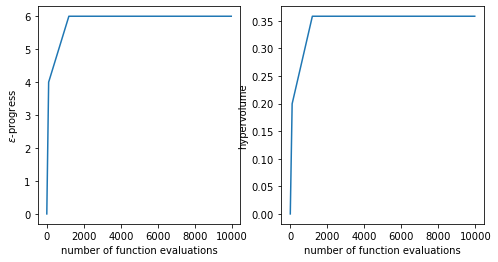

<Figure size 432x288 with 0 Axes>

In [59]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True, figsize=(8,4))
ax1.plot(convergence['nfe'], convergence['epsilon_progress'])
ax1.set_ylabel('$\epsilon$-progress')
ax2.plot(convergence['nfe'], convergence['hypervolume'])
ax2.set_ylabel('hypervolume')

ax1.set_xlabel('number of function evaluations')
ax2.set_xlabel('number of function evaluations')
plt.show()
plt.savefig('./results/opt_WCS_convergence')

In [60]:
archive

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2,fraction EA deaths,fraction EA damage,fraction DIC,fraction RfR IC,fraction minWL,fraction maxWL
0,1,1,1,0,1,0,0,0,0,0,...,6,1,1,6,0.666667,0.0,0.0,0.0,1.0,0.0


In [61]:
archive.T

,0
0_RfR 0,1.000000
0_RfR 1,1.000000
0_RfR 2,1.000000
1_RfR 0,0.000000
1_RfR 1,1.000000
1_RfR 2,0.000000
2_RfR 0,0.000000
2_RfR 1,0.000000
2_RfR 2,0.000000
3_RfR 0,0.000000


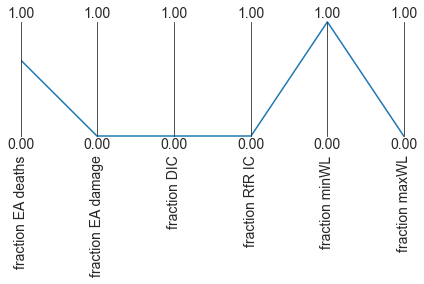

In [62]:
from ema_workbench.analysis import parcoords

data = archive.loc[:, [o.name for o in robustnes_functions]]
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
limits.loc[1, :] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
plt.show()

In [44]:
# run found policy to find the costs 
# note that the number of deaths and annual damage that are calculated below account for 75 years,
# in which 50 have not been assigned policies, so their outcomes are not representable for the policy effects
# in the coming 25 years

In [40]:
Dike_investment_costs = Policy( **{l.name:0 for l in dike_model.levers})
Dike_investment_costs['A.1_DikeIncrease 0'] = 10
Dike_investment_costs['A.2_DikeIncrease 0'] = 2
Dike_investment_costs['A.3_DikeIncrease 0'] = 0
Dike_investment_costs['A.4_DikeIncrease 0'] = 7
Dike_investment_costs['A.5_DikeIncrease 0'] = 7

In [41]:
random.seed(3922875)
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(scenarios=2,               
                                            policies=Dike_investment_costs)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 2 scenarios * 1 policies * 1 model(s) = 2 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [42]:
experiments, outcomes = results

In [43]:
outcomes

{'Expected Annual Damage': array([1.51422853e+09, 1.09953468e+08]),
 'Dike Investment Costs': array([1.96380912e+08, 1.96380912e+08]),
 'RfR Investment Costs': array([0., 0.]),
 'Expected Number of Deaths': array([2.84281988, 0.12669273]),
 'Min Waterlevel': array([4.83654737, 4.5385    ]),
 'Max Waterlevel': array([10.93159077, 10.94510015])}

In [45]:
# costs of designed policy is 196million